##### Imports & Global Setting

In [1]:
import os
import random
import pickle
import gzip
import gc
import re
import warnings
warnings.filterwarnings("ignore")  # 불필요한 경고 메시지 숨김

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from tqdm import tqdm, tqdm_notebook



from sklearn.impute import SimpleImputer  # 결측값 처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder  # 데이터 스케일링 & 인코딩
from sklearn.cluster import KMeans  # 군집화 (클러스터링)
from lightgbm import LGBMClassifier  # LightGBM
from catboost import CatBoostClassifier  # CatBoost
from xgboost import XGBClassifier  # XGBoost
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier  # 앙상블 모델
from sklearn.model_selection import cross_val_score, KFold  # 교차 검증 (K-Fold)
from sklearn.metrics import accuracy_score  # 정확도 평가
import shap  # SHAP 값 계산을 통한 피처 중요도 분석
%matplotlib inline  


### 데이터 설명
- **패널(Panel) 데이터**
  - userID: 패널 ID
  - BIRTH: 생일(연도)
  - GENDER: 1(남자) 2(여자)
  - REGION: 거주지역
  - TYPE: 패널 구분
  - SQ1 ~ DQ7: 패널 가입 시 설문조사 데이터 상세정보 참가자에 한하여 제공
- **설문(Survey) 데이터**
  - surveyID: 설문 ID
  - TITLE: 설문 제목
  - IR: 난이도(응답가능성, 100이 최고)
  - LOI: 설문하는데 걸리는 시간 (분단위)
  - CATEGORIES: 설문 분류
  - CPI: 패널 응답 리워드 포인트(1P~)
- **응답(Response) 데이터**
  - STATUS: 응답여부 (Target)
  - (test 데이터의) ID: submission을 식별하기 위한 ID로 사용

# 01. Data Loading

In [3]:
train = pd.read_csv('train.csv', encoding='cp949')
test = pd.read_csv('test.csv', encoding='cp949')

In [4]:
original_features = train.columns
original_features

Index(['userID', 'surveyID', 'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ1', 'SQ2',
       'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4',
       'B5', 'C1', 'C2', 'C3', 'F1', 'F2', 'H1', 'T1', 'X1', 'X2', 'X3', 'X4',
       'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6', 'DQ7', 'TITLE', 'IR', 'LOI',
       'CATEGORIES', 'CPI', 'STATUS'],
      dtype='object')

# 02. Data Preprocessing

##### Clean data & derive features

In [5]:
# 결측값 비율이 30% 이하인 column만 사용(사용할 피처들만 출력)
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] <= 0.3:
        print(f, '\t', train[f].nunique(), '\t', train[f].isnull().sum()/train.shape[0])
        features.append(f)

userID 	 15155 	 0.0
surveyID 	 1293 	 0.0
BIRTH 	 76 	 0.0
GENDER 	 2 	 0.0
REGION 	 17 	 0.0
TYPE 	 3 	 0.0
SQ1 	 2 	 0.0009770785964481042
SQ2 	 82 	 0.0014293615190806859
SQ3 	 47 	 0.09023044306520002
SQ4 	 52 	 0.09058931973207153
SQ5 	 273 	 0.14450930989983407
SQ6 	 30 	 0.14490751551649972
SQ7 	 1234 	 0.1802556381736619
SQ8 	 1774 	 0.1831610643397038
A1 	 2768 	 0.2083279051189086
B1 	 131 	 0.21447796964296686
B2 	 120 	 0.2426792847047256
B3 	 110 	 0.24790757696798377
B4 	 715 	 0.2602888219750507
B5 	 669 	 0.26743317151109197
TITLE 	 1286 	 0.0
IR 	 42 	 0.0
LOI 	 26 	 0.0
CPI 	 43 	 0.0
STATUS 	 2 	 0.0


In [6]:
# 불필요한 ID들은 제외. SQ1 ~ SQ3는 GENDER, BIRTH, REGION과 중복이어서 제외!
# features.remove('userID')
# features.remove('surveyID')
features.remove('STATUS')
features.remove('SQ1')
features.remove('SQ2')
features.remove('SQ3')

In [7]:
# 거주 주택 형태: 1/2/3/4/5/6/97이 정상값
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,']:
        return int(x[0])
    else:
        return 99

train.SQ4 = train.SQ4.apply(handle_profile)
test.SQ4 = test.SQ4.apply(handle_profile)

In [8]:
# 최종학력: 1/2/3/4 정상값
def handle_profile(x):
    if x in ['1', '2', '3', '4']:
        return int(x)
    elif x in ['1.0', '2.0', '3.0', '4.0']:
        return int(x[0])
    else:
        return 99

train.SQ5 = train.SQ5.apply(handle_profile)
test.SQ5 = test.SQ5.apply(handle_profile)

In [9]:
# 결혼여부: 1/2/97 정상값
def handle_profile(x):
    if x in ['1', '2']:
        return int(x)
    elif x in ['1,', '2,']:
        return int(x[0])
    else:
        return 99

train.SQ6 = train.SQ6.apply(handle_profile)
test.SQ6 = test.SQ6.apply(handle_profile)

In [10]:
# 자녀 정보: 1~16/99 정상값
value1 = pd.Series(range(1,17)).apply(lambda x: str(x)).tolist()
value2 = pd.Series(np.arange(1.0,17.0)).apply(lambda x: str(x)).tolist()
def handle_profile(x):
    if x in value1:
        return int(x)
    elif x in value2:
        return int(x[0])
    else:
        return 99

train.SQ7 = train.SQ7.apply(handle_profile)
test.SQ7 = test.SQ7.apply(handle_profile)

In [11]:
# 가족수: 1/2/3/4/5 정상값
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5']:
        return int(x)
    else:
        return 99

train.SQ8 = train.SQ8.apply(handle_profile)
test.SQ8 = test.SQ8.apply(handle_profile)

In [12]:
# 최근 구입/렌트 가전제품: 1~22/99 정상값
values = pd.Series(range(1,23)).apply(lambda x: str(x)).tolist()
def handle_profile(x):    
    if x in values:
        return int(x)
    else:
        return 99

train.A1 = train.A1.apply(handle_profile)
test.A1 = test.A1.apply(handle_profile)

In [13]:
# 휴대폰 통신망 종류: 1~8/99 정상값
def handle_profile(x):    
    if x in ['1']:
        return 2
    elif x in ['2', '3']:
        return 3
    elif x in ['4', '5', '6', '7']:
        return 4
    elif x in ['8']:
        return 5
    else:
        return 99

train.B1 = train.B1.apply(handle_profile)
test.B1 = test.B1.apply(handle_profile)

In [14]:
# 가입한 이동통신사: 1~6/97 정상값 
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    else:
        return 99

train.B2 = train.B2.apply(handle_profile)
test.B2 = test.B2.apply(handle_profile)

In [15]:
# 휴대폰 브랜드: 1~7/97/99 --1등
def handle_profile(x):    
    if x in ['1', '2', '3']:
        return int(x)
    elif x in ['1,', '2,', '3,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B3 = train.B3.apply(handle_profile)
test.B3 = test.B3.apply(handle_profile)

In [16]:
# 보유 스마트 기기: 1~7/97/99  --1등
def handle_profile(x):    
    if x != x :
        return 0
    elif x in ['1', '2', '3', '4', '5', '6', '7' , '99', '97']:
        return int(x)
    else:
        return 98

train.B4 = train.B4.apply(handle_profile)
test.B4 = test.B4.apply(handle_profile)

In [17]:
# 케이블TV: 1~10/97/99  --1등
def handle_profile(x):    
    if x != x :
        return 0
    elif x in ['1', '2', '3', '4' ,'5', '6', '7', '8', '9', '10']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,' ,'5,', '6,', '7,', '8,', '9,', '10,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B5 = train.B5.apply(handle_profile)
test.B5 = test.B5.apply(handle_profile)

In [18]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,', '7,', '8,', '9,', '10,', '11,', '12,', '13,', '14,']:
        return int(x[0])
    else:
        return 99

train.C1 = train.C1.apply(handle_profile)
test.C1 = test.C1.apply(handle_profile)

In [19]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,', '7,', '8,', '9,', '10,', '11,', '12,', '13,', '14,']:
        return int(x[0])
    else:
        return 99

train.C2 = train.C2.apply(handle_profile)
test.C2 = test.C2.apply(handle_profile)

In [20]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,', '7,', '8,', '9,', '10,']:
        return int(x[0])
    else:
        return 99

train.C3 = train.C3.apply(handle_profile)
test.C3 = test.C3.apply(handle_profile)

### **< train_TITLE >** 피처

In [21]:
train_TITLE = train.copy()
test_TITLE = test.copy()

# 03. 피처추가 Feature Generation(FE_GN)

#### 01. 'RESRATE_round' : 응답률(RESRATE) 구간화

In [22]:
# 01. [RESRATE_round] : 응답률(RESRATE) 구간화

res_freq = train.query('STATUS == 1').groupby('userID')['userID'].agg([('FREQ',np.size)]).reset_index()
send_freq = train.groupby('userID')['userID'].agg([('SEND',np.size)]).reset_index()

train = train.merge(res_freq, how='left').merge(send_freq, how='left')
train['RESRATE'] = train['FREQ'] / train['SEND']
del train['FREQ'], train['SEND']
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'RESRATE']], how='left')
test['RESRATE'] = test['RESRATE'].fillna(0)


#features.extend(['RESRATE'])    --> 피처 추가는 round된 버전으로!

# 구간화
train['RESRATE_round'] = round(train['RESRATE'],3) 
test['RESRATE_round'] = round(test['RESRATE'],3) 

features.extend(['RESRATE_round'])

In [23]:
train['RESRATE'].value_counts()

0.750000    4168
0.500000    3746
0.857143    2471
0.666667    2406
0.250000    2276
            ... 
0.184211      38
0.194444      36
0.147059      34
0.393939      33
0.593750      32
Name: RESRATE, Length: 2441, dtype: int64

In [24]:
train['TYPE'].value_counts()

D    363127
B    332546
C    117977
Name: TYPE, dtype: int64

#### 02. 'TYPE_RES_RATE' : 타입별 응답률

In [25]:
# 02. ['TYPE_RES_RATE'] : 타입별 응답률

response = train.groupby('TYPE')['STATUS'].agg([('TYPE_RES_RATE', lambda x: np.mean(x))]).reset_index()
train = train.merge(response, how='left', on='TYPE')
test = test.merge(response, how='left', on='TYPE')

features.extend(['TYPE_RES_RATE'])

In [26]:
response

,TYPE,TYPE_RES_RATE
0,B,0.259919
1,C,0.067496
2,D,0.611816


In [27]:
train[['TYPE', 'TYPE_RES_RATE']]

,TYPE,TYPE_RES_RATE
0,D,0.611816
1,D,0.611816
2,D,0.611816
3,D,0.611816
4,D,0.611816
...,...,...
813645,D,0.611816
813646,D,0.611816
813647,D,0.611816
813648,D,0.611816


#### 03. '리워드/시간'

In [28]:
# 03. ['리워드/시간'] 

train['리워드/시간'] = train['CPI'] / train['LOI']
test['리워드/시간'] = test['CPI'] / test['LOI']
features.extend(['리워드/시간'])

#### 04. '-(시간+난이도)_scaled' : -(시간+난이도) 스케일 진행

In [29]:
# 04. ['-(시간+난이도)_scaled'] : -(시간+난이도) 스케일 진행

# IR 피처에 대한 Min-Max Scaling
scaler = MinMaxScaler(feature_range=(1, 35))  # LOI의 범위에 맞춰서 설정
train['IR_scaled'] = scaler.fit_transform(train['IR'].values.reshape(-1, 1))
test['IR_scaled'] = scaler.fit_transform(test['IR'].values.reshape(-1, 1))

# 시간과 난이도의 합을 계산하여 새로운 피처 생성
train['-(시간+난이도)_scaled'] = -(train['IR_scaled'] + train['LOI'])
test['-(시간+난이도)_scaled'] = -(test['IR_scaled'] + test['LOI'] )
features.extend(['-(시간+난이도)_scaled'])

#### 05. '대상지역', '대상자유형_일반인', '대상자유형_소비자'

In [30]:
# 05. ['대상지역', '대상자유형_일반인', '대상자유형_소비자']

'''TRAIN'''
대상지역 = np.where(train_TITLE['TITLE'].str.contains('해외'), '해외', '기타')
대상자유형_일반인 = np.where(train_TITLE['TITLE'].str.contains('일반인'), '일반인', '기타')
대상자유형_소비자 = np.where(train_TITLE['TITLE'].str.contains('소비자'), '소비자', '기타')

### 생성된 배열을 시리즈로 변환
대상지역 = pd.Series(대상지역, name='대상지역')
대상자유형_일반인 = pd.Series(대상자유형_일반인, name='대상자유형_일반인')
대상자유형_소비자 = pd.Series(대상자유형_소비자, name='대상자유형_소비자')

### 데이터프레임에 병합
train = pd.concat([train, 대상지역, 대상자유형_일반인, 대상자유형_소비자], axis=1)

In [31]:
'''TEST'''
대상지역 = np.where(test_TITLE['TITLE'].str.contains('해외'), '해외', '기타')
대상자유형_일반인 = np.where(test_TITLE['TITLE'].str.contains('일반인'), '일반인', '기타')
대상자유형_소비자 = np.where(test_TITLE['TITLE'].str.contains('소비자'), '소비자', '기타')

### 생성된 배열을 시리즈로 변환
대상지역 = pd.Series(대상지역, name='대상지역')
대상자유형_일반인 = pd.Series(대상자유형_일반인, name='대상자유형_일반인')
대상자유형_소비자 = pd.Series(대상자유형_소비자, name='대상자유형_소비자')

### 데이터프레임에 병합
test = pd.concat([test, 대상지역, 대상자유형_일반인, 대상자유형_소비자], axis=1)

features.extend(['대상지역', '대상자유형_일반인', '대상자유형_소비자'])

#### 06. 'Points_earned_bins' 

In [32]:
# 06. '[Points_earned_bins'] : 패널 ID 별 획득 누적 포인트

#Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()
Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

# 패널 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()

train = train.merge(Points_earned, how='left')
train = train.merge(Points_earned_mean, how='left')
train['Points_earned'].fillna(0, inplace = True)
train['Points_earned_mean'].fillna(0, inplace = True)

test = test.merge(Points_earned, how='left')
test = test.merge(Points_earned_mean, how='left')
test['Points_earned'].fillna(0, inplace = True)
test['Points_earned_mean'].fillna(0, inplace = True)

#features.extend(['Points_earned_mean'])

'''구간화'''
# 0부터 1170까지는 20씩, 1200에서 2000까지는 하나의 구간으로 설정
bin_edges = list(range(0, 1200, 20)) + [2000]

# 구간에 대한 라벨 설정
bin_labels = [f'{i}-{i+19}' for i in range(0, 1180, 20)] + ['1200-2000']

# 'Points_earned_mean' 열을 구간화하여 새로운 열로 추가
train['Points_earned_bins'] = pd.cut(train['Points_earned_mean'], bins=bin_edges, labels=bin_labels, include_lowest=True)
test['Points_earned_bins'] = pd.cut(test['Points_earned_mean'], bins=bin_edges, labels=bin_labels, include_lowest=True)

features.append('Points_earned_bins')

#### 07. 'Status_sum_log'

In [33]:
# 응답 횟수(참여 횟수) 계산
Status_sum = train.groupby('userID')['STATUS'].sum()

# 데이터에 병합
train = train.merge(Status_sum.rename('Status_sum'), on='userID', how='left')
test = test.merge(Status_sum.rename('Status_sum'), on='userID', how='left')

# 로그 변환 후 새로운 피처 생성
train['Status_sum_log'] = np.log(train['Status_sum'] + 1)
test['Status_sum_log'] = np.log(test['Status_sum'] + 1)

# 피처 리스트에 추가
features.extend(['Status_sum_log'])


#### 08. 'RESRATE_S_round'

In [34]:
# 설문별 응답률 (RESRATE_S) 생성
res_freq = train.query('STATUS == 1').groupby('surveyID')['surveyID'].agg([('FREQ',np.size)]).reset_index()
send_freq = train.groupby('surveyID')['surveyID'].agg([('SEND',np.size)]).reset_index()

train = train.merge(res_freq, how='left').merge(send_freq, how='left')
train['RESRATE_S'] = train['FREQ'] / train['SEND']
del train['FREQ'], train['SEND']

test = pd.merge(test, train.drop_duplicates(subset=['surveyID'])[['surveyID', 'RESRATE_S']], how='left')
test['RESRATE_S'] = test['RESRATE_S'].fillna(0)

features.extend(['RESRATE_S'])


# RESRATE_S 구간화
train['RESRATE_S_round'] = round(train['RESRATE_S'],3) 
test['RESRATE_S_round'] = round(test['RESRATE_S'],3) 

features.extend(['RESRATE_S_round'])

In [35]:
# Survey 제목에서 유용한 정보 추출 
word_counts = {}
def count_word(x): # 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

# 04. 데이터 필터링


In [36]:
#데이터 필터링
X_train = train[features]
X_test = test[features]
y_train = train['STATUS']

# submission을 만들 때 사용하기 위해 ID 저정
ID_test = test.ID

# 메모리 낭비를 막기위해 불필요한 데이터 삭제
del train, test 
gc.collect()

10

# 05. Feature Engineering

In [37]:
# 범주형 변수와 수치형 변수를 분리
def separate_features(df):
    num_features = df.select_dtypes(include=['number']).columns.tolist()
    cat_features = df.select_dtypes(exclude=['number']).columns.tolist()
    return num_features, cat_features

num_features, cat_features = separate_features(X_train)

In [38]:
print(len(num_features))
print(len(cat_features))

25
7


##### 1) Impute missing values

In [39]:
# 범주형이냐 수치형이냐에 따라 다르게 처리
if len(num_features) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_features] = imp.fit_transform(X_train[num_features])
    X_test[num_features] = imp.transform(X_test[num_features])
if len(cat_features) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[cat_features] = imp.fit_transform(X_train[cat_features])
    X_test[cat_features] = imp.transform(X_test[cat_features])


X_train['GENDER'] = X_train['GENDER'].astype(int)
X_train['REGION'] = X_train['REGION'].astype(int)
X_test['GENDER'] = X_test['GENDER'].astype(int)
X_test['REGION'] = X_test['REGION'].astype(int)

##### 2) Transform features (Feature Scaling)

In [40]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

##### 3) Encode categorical features

In [41]:
Oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
X_train[cat_features] = Oe.fit_transform(X_train[cat_features])
X_test[cat_features] = Oe.transform(X_test[cat_features])

In [42]:
# SHAP 이전 컬럼 개수
print(X_train.shape)
print(X_test.shape)
print(len(features))
print(features)

(813650, 32)
(541867, 32)
32
['userID', 'surveyID', 'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'TITLE', 'IR', 'LOI', 'CPI', 'RESRATE_round', 'TYPE_RES_RATE', '리워드/시간', '-(시간+난이도)_scaled', '대상지역', '대상자유형_일반인', '대상자유형_소비자', 'Points_earned_bins', 'Status_sum_log', 'RESRATE_S', 'RESRATE_S_round']


<font color="#CC3D3D"><p>
### **Feature selection using SHAP**

[LightGBM] [Info] Number of positive: 316565, number of negative: 497085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1972
[LightGBM] [Info] Number of data points in the train set: 813650, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389068 -> initscore=-0.451232
[LightGBM] [Info] Start training from score -0.451232


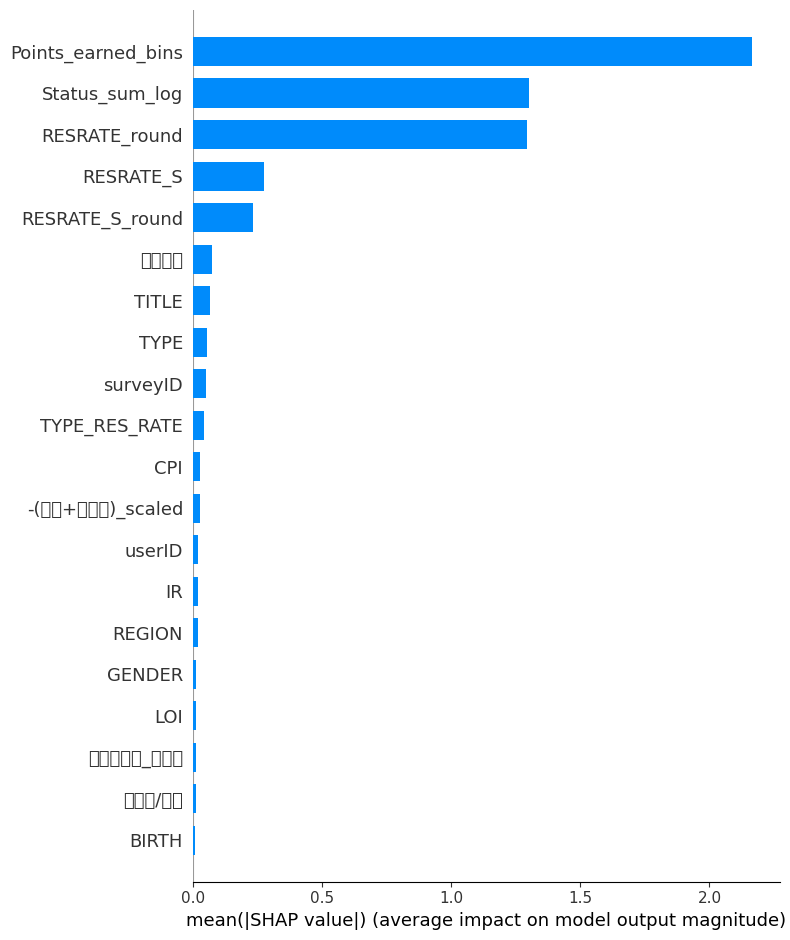

,column_name,shap_importance
28,Points_earned_bins,2.164838
29,Status_sum_log,1.301244
21,RESRATE_round,1.291911
30,RESRATE_S,0.277777
31,RESRATE_S_round,0.233517
25,대상지역,0.074215
17,TITLE,0.067787
5,TYPE,0.055885
1,surveyID,0.049974
22,TYPE_RES_RATE,0.042586


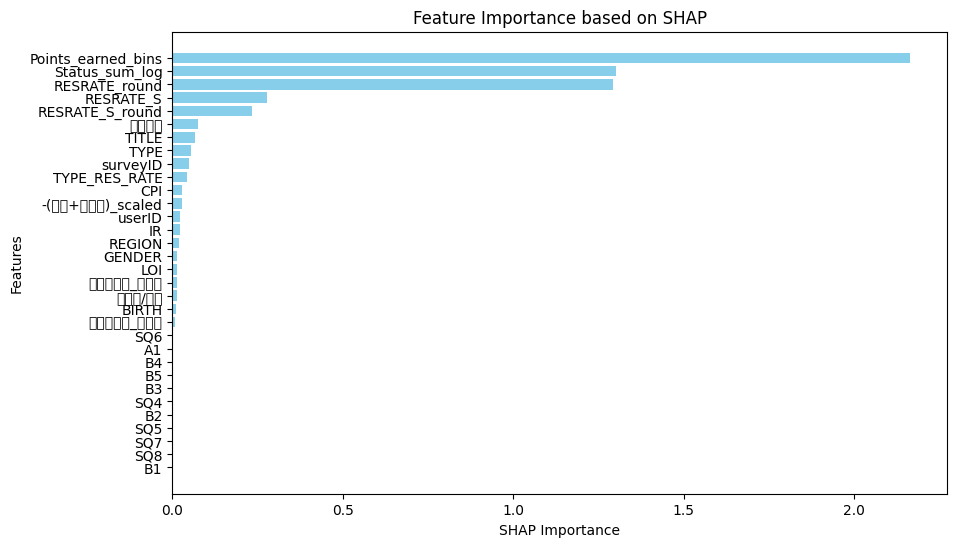

In [43]:
# LightGBM 모델 학습

X_importance = X_test

model = LGBMClassifier(random_state=0).fit(X_train, y_train)

# SHAP Explainer 생성 및 SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# SHAP Summary Plot (막대그래프)
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# SHAP 중요도 계산 (axis=0 수정)
shap_sum = np.abs(shap_values).mean(axis=0)  # 

# 피처 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'column_name': X_importance.columns,
    'shap_importance': shap_sum
}).sort_values('shap_importance', ascending=False)

# 중요도 데이터프레임 출력
display(importance_df)  # Jupyter 환경에서 시각적으로 확인
# print(importance_df.head(10))  # 상위 10개만 출력

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df["column_name"], importance_df["shap_importance"], color='skyblue')
plt.xlabel("SHAP Importance")
plt.ylabel("Features")
plt.title("Feature Importance based on SHAP")
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.show()


In [47]:
# 지정된(SHAP_THRESHOLD) Shap feature 중요도 이상인 것만 선택
SHAP_THRESHOLD = 0.0001  

#32 -> 29
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]

print(X_train.shape)

(813650, 29)


In [48]:
X_train

,Points_earned_bins,Status_sum_log,RESRATE_round,RESRATE_S,RESRATE_S_round,대상지역,TITLE,TYPE,surveyID,TYPE_RES_RATE,...,BIRTH,대상자유형_일반인,SQ6,A1,B4,B5,B3,SQ4,B2,SQ5
0,32,1.934314,1.726479,1.861661,1.862850,1,0.632637,2,18,1.062459,...,-0.329418,1,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.487165,0.631978,0.565725
1,32,1.934314,1.726479,1.468151,1.469490,1,0.632637,2,19,1.062459,...,-0.329418,1,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.487165,0.631978,0.565725
2,32,1.934314,1.726479,-0.321342,-0.322485,1,0.632637,2,27,1.062459,...,-0.329418,1,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.487165,0.631978,0.565725
3,32,1.934314,1.726479,-0.631940,-0.633288,1,0.632637,2,28,1.062459,...,-0.329418,1,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.487165,0.631978,0.565725
4,32,1.934314,1.726479,-0.581945,-0.579869,1,0.632637,2,30,1.062459,...,-0.329418,1,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.487165,0.631978,0.565725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813645,33,0.310619,-0.327473,0.610627,0.609925,0,-1.453760,2,998,1.062459,...,0.244014,0,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.406041,0.631978,0.565725
813646,33,0.310619,-0.327473,1.056260,1.056704,0,-1.453760,2,1127,1.062459,...,0.244014,0,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.406041,0.631978,0.565725
813647,33,0.310619,-0.327473,0.596492,0.595356,0,-1.453760,2,1163,1.062459,...,0.244014,0,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.406041,0.631978,0.565725
813648,33,0.310619,-0.327473,1.461437,1.459777,0,-1.362866,2,1220,1.062459,...,0.244014,1,-0.766743,0.783333,-0.841438,-0.402457,-0.267413,-0.406041,0.631978,0.565725


In [49]:
### 데이터 변환
'''import numpy as np

# 전체 피처에 대해 sqrt 스케일링 적용
arbitrary_number = 1
X_train = np.sqrt(X_train + arbitrary_number)
X_test = np.sqrt(X_test + arbitrary_number)
'''

'import numpy as np\n\n# 전체 피처에 대해 sqrt 스케일링 적용\narbitrary_number = 1\nX_train = np.sqrt(X_train + arbitrary_number)\nX_test = np.sqrt(X_test + arbitrary_number)\n'

# **06. Model building**

#### LGBM

In [50]:
model_lgbm = LGBMClassifier(n_estimators=4000, learning_rate=0.05, objective='binary', metric='binary_error', random_state=44)
lgbm_pred = np.zeros((X_test.shape[0]))
accuracy_list = []
list_lgbm = []

threshold = 0.5 
spl = 5

kf = KFold(n_splits=spl, shuffle=True, random_state=42)

for tr_idx, val_idx in tqdm(kf.split(X_train, y_train)):
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    model_lgbm.fit(tr_x, tr_y, eval_metric = 'accuracy')
    pred = model_lgbm.predict(val_x)

    accuracy = accuracy_score(val_y, pred)
    accuracy_list.append(accuracy)
    print(accuracy)
    
    sub_pred = np.array(model_lgbm.predict_proba(X_test)[:, 1])  # X_test에 대한 예측값 구하기
    lgbm_pred += sub_pred

# 최종 예측값 구하기 (5-fold의 평균값 사용)
final_predictions_lgbm = (lgbm_pred / spl >= 0.495).astype(int)
print(final_predictions_lgbm)
print(f'{model_lgbm.__class__.__name__}의 fold 평균 Accuracy는 {np.mean(accuracy_list)}')

0it [00:00, ?it/s]

[LightGBM] [Info] Number of positive: 253249, number of negative: 397671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389063 -> initscore=-0.451252
[LightGBM] [Info] Start training from score -0.451252
0.8697843052909727


1it [03:34, 214.12s/it]

[LightGBM] [Info] Number of positive: 253255, number of negative: 397665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1935
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389072 -> initscore=-0.451213
[LightGBM] [Info] Start training from score -0.451213
0.8699256437042955


2it [07:14, 218.00s/it]

[LightGBM] [Info] Number of positive: 253497, number of negative: 397423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1938
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389444 -> initscore=-0.449649
[LightGBM] [Info] Start training from score -0.449649
0.8713205923923063


3it [10:51, 217.32s/it]

[LightGBM] [Info] Number of positive: 253073, number of negative: 397847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388793 -> initscore=-0.452390
[LightGBM] [Info] Start training from score -0.452390
0.8709211577459596


4it [15:04, 231.44s/it]

[LightGBM] [Info] Number of positive: 253186, number of negative: 397734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1938
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388966 -> initscore=-0.451659
[LightGBM] [Info] Start training from score -0.451659
0.869421741535058


5it [18:42, 224.43s/it]

[1 1 1 ... 0 0 1]
LGBMClassifier의 fold 평균 Accuracy는 0.8702746881337184


#### XGB

In [51]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# 최적의 하이퍼파라미터 설정
best_params = {
    'n_estimators': 5000,
    'max_depth': 15,
    'learning_rate': 0.1,
    'subsample': 0.95,
    'colsample_bytree': 0.95,
    'gamma': 1e-8,
    'min_child_weight': 20,
    'random_state': 0,
    'eval_metric': 'error',
    'objective': 'binary:logistic',
    'verbosity': 0
}

model_xgb = XGBClassifier(**best_params)
xgb_pred = np.zeros((X_test.shape[0]))
accuracy_list = []
spl = 5

kf = KFold(n_splits=spl, shuffle=True, random_state=42)

for tr_idx, val_idx in tqdm(kf.split(X_train, y_train)):
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    model_xgb.fit(tr_x, tr_y)
    pred = model_xgb.predict(val_x)

    accuracy = accuracy_score(val_y, pred)
    accuracy_list.append(accuracy)
    print(accuracy)
    
    sub_pred = np.array(model_xgb.predict_proba(X_test)[:, 1])  # X_test에 대한 예측값 구하기
    xgb_pred += sub_pred

# 최종 예측값 구하기 (5-fold의 평균값 사용)
final_predictions_xgb = (xgb_pred / spl >= 0.495).astype(int)
print(final_predictions_xgb)
print(f'{model_xgb.__class__.__name__}의 fold 평균 Accuracy는 {np.mean(accuracy_list)}')

0it [00:00, ?it/s]

0.859945922694033


1it [04:35, 275.42s/it]

0.8598414551711424


2it [09:20, 281.15s/it]

0.8607140662446998


3it [13:56, 278.82s/it]

0.8597369876482517


4it [18:33, 278.16s/it]

0.8582560068825662


5it [23:09, 277.97s/it]

[1 1 1 ... 0 0 1]
XGBClassifier의 fold 평균 Accuracy는 0.8596988877281386


#### CAT

In [52]:
model_cb = CatBoostClassifier(eval_metric= 'Accuracy',loss_function = "CrossEntropy", random_state=0, verbose = 200)
lgbm_pred = np.zeros((X_test.shape[0]))
accuracy_list = []
list_lgbm = []
spl = 5

kf = KFold(n_splits=spl, shuffle=True, random_state=42)

for tr_idx, val_idx in tqdm(kf.split(X_train, y_train)):
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    model_cb.fit(tr_x, tr_y)
    pred = model_cb.predict(val_x)

    accuracy = accuracy_score(val_y, pred)
    accuracy_list.append(accuracy)
    print(accuracy)
    
    sub_pred = np.array(model_cb.predict_proba(X_test)[:, 1])  # X_test에 대한 예측값 구하기
    lgbm_pred += sub_pred

# 최종 예측값 구하기 (5-fold의 평균값 사용)
final_predictions_cb = (lgbm_pred / spl >= 0.495).astype(int)
print(final_predictions_cb)
print(f'{model_cb.__class__.__name__}의 fold 평균 Accuracy는 {np.mean(accuracy_list)}')

0it [00:00, ?it/s]

0:	learn: 0.8423739	total: 109ms	remaining: 1m 49s
200:	learn: 0.8608984	total: 10s	remaining: 39.8s
400:	learn: 0.8636453	total: 19.6s	remaining: 29.3s
600:	learn: 0.8653368	total: 29.3s	remaining: 19.5s
800:	learn: 0.8663399	total: 38.9s	remaining: 9.67s
999:	learn: 0.8673047	total: 48.4s	remaining: 0us
0.865759233085479


1it [00:49, 49.06s/it]

0:	learn: 0.8431773	total: 86.2ms	remaining: 1m 26s
200:	learn: 0.8605866	total: 9.94s	remaining: 39.5s
400:	learn: 0.8637774	total: 19.6s	remaining: 29.3s
600:	learn: 0.8654673	total: 29.4s	remaining: 19.5s
800:	learn: 0.8665919	total: 39.1s	remaining: 9.72s
999:	learn: 0.8673938	total: 48.8s	remaining: 0us
0.8660480550605297


2it [01:38, 49.27s/it]

0:	learn: 0.8428793	total: 64.7ms	remaining: 1m 4s
200:	learn: 0.8603023	total: 9.9s	remaining: 39.4s
400:	learn: 0.8634364	total: 19.5s	remaining: 29.1s
600:	learn: 0.8651893	total: 29.3s	remaining: 19.5s
800:	learn: 0.8664045	total: 39s	remaining: 9.69s
999:	learn: 0.8672817	total: 48.6s	remaining: 0us
0.8674614391937565


3it [02:27, 49.21s/it]

0:	learn: 0.8423170	total: 60.2ms	remaining: 1m
200:	learn: 0.8606618	total: 9.82s	remaining: 39s
400:	learn: 0.8638450	total: 19.6s	remaining: 29.2s
600:	learn: 0.8654750	total: 29.2s	remaining: 19.4s
800:	learn: 0.8663830	total: 38.8s	remaining: 9.64s
999:	learn: 0.8671972	total: 48.3s	remaining: 0us
0.8666810053462791


4it [03:16, 49.09s/it]

0:	learn: 0.8445738	total: 64.3ms	remaining: 1m 4s
200:	learn: 0.8607617	total: 9.83s	remaining: 39.1s
400:	learn: 0.8637037	total: 19.4s	remaining: 29s
600:	learn: 0.8653890	total: 29.2s	remaining: 19.4s
800:	learn: 0.8664429	total: 39s	remaining: 9.69s
999:	learn: 0.8673954	total: 48.6s	remaining: 0us
0.8656732010078043


5it [04:05, 49.14s/it]

[1 1 1 ... 0 0 1]
CatBoostClassifier의 fold 평균 Accuracy는 0.8663245867387698


In [53]:
# 세 모델의 예측값을 하드보팅
avg_predictions = (final_predictions_lgbm + final_predictions_xgb + final_predictions_cb) / 3

threshold = 0.5  # 임계값 설정
final_predictions = np.where(avg_predictions >= threshold, 1, 0)

print(final_predictions)

[1 1 1 ... 0 0 1]


In [54]:
len(final_predictions)

541867

In [55]:
t = pd.Timestamp.now()
fname = f"oof_hardvoting_submission)_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'ID': ID_test, 'STATUS': final_predictions}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'oof_hardvoting_submission)_02021346.csv' is ready to submit.
